In [1]:
import torch
import sys, os
import numpy as np
import pandas as pd
import torch.nn as nn
from pathlib import Path
from datetime import datetime
from ema_pytorch import EMA
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.distributions import Normal
from utils.sim_utils import *
from utils.couzin_utils import *
from utils.encoder_utils import *
from multiprocessing import Pool, set_start_method
from models.ModularNetworks import PairwiseInteraction, Attention
from torch.utils.data import TensorDataset, DataLoader
from utils.train_utils import compute_wasserstein_loss, gradient_penalty

sys.path.insert(0, os.path.abspath('..'))

In [ ]:
""" 
Optimizations:
- GRN/Temporal-CNN oder 1D-CNN als Encoder für Sequenzen
- Feature Clustering/Reward Weighting
"""

In [2]:
class Discriminator(nn.Module):
    def __init__(self, encoder, z_dim=32):
        super(Discriminator, self).__init__()
        self.encoder = encoder
        self.z_dim = z_dim
        self.input_dim = 2 * z_dim

        self.fc1 = nn.Linear(self.input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def encoder_forward(self, tensor):
        states = tensor[..., :4]
        _, trans = self.encoder(states)
        batch, frames_minus_one, agent, neigh_rep = trans.shape
        feats = trans.reshape(batch * frames_minus_one * agent, neigh_rep)
        return feats, (batch, frames_minus_one, agent)

    def forward(self, tensor):
        features, shape = self.encoder_forward(tensor)
        batch, frames_minus_one, agent = shape

        params = torch.relu(self.fc1(features))
        params = torch.relu(self.fc2(params))
        params = torch.relu(self.fc3(params))
        params = self.fc4(params).squeeze(-1)

        params = params.view(batch, frames_minus_one, agent)
        scores = params.mean(dim=(1, 2))
        return scores

    def update(self, expert_batch, policy_batch, optim_dis, lambda_gp,
               noise=0, generation=None, num_generations=None):

        if noise > 0.0:
            noise_until = 0.5 * num_generations
            decay = 1.0 - (generation / noise_until)
            decay = max(0.0, decay)
            noise_term = noise * decay

            expert_batch = expert_batch.clone()
            policy_batch = policy_batch.clone()

            expert_batch = expert_batch + torch.randn_like(expert_batch) * noise_term 
            policy_batch = policy_batch + torch.randn_like(policy_batch) * noise_term

        exp_scores = self.forward(expert_batch)
        gen_scores = self.forward(policy_batch)

        grad_penalty = gradient_penalty(self, expert_batch, policy_batch)

        loss, loss_gp = compute_wasserstein_loss(exp_scores, gen_scores, lambda_gp, grad_penalty)

        optim_dis.zero_grad()
        loss_gp.backward()
        optim_dis.step()

        return {
            "dis_loss": round(loss.item(), 4),
            "dis_loss_gp": round(loss_gp.item(), 4),
            "grad_penalty": round(grad_penalty.item(), 4),
            "expert_score_mean": round(exp_scores.mean().item(), 4),
            "policy_score_mean": round(gen_scores.mean().item(), 4),
        }

    def set_parameters(self, init=True):
        if init is True:
            for layer in self.modules():
                if hasattr(layer, 'reset_parameters'):
                    layer.reset_parameters()


In [3]:
class ModularPolicy(nn.Module):
    def __init__(self, features=4):
        super(ModularPolicy, self).__init__()

        self.pairwise = PairwiseInteraction(features)
        self.attention = Attention(features)

    def forward(self, states, deterministic=True):
        mu, sigma = self.pairwise(states)

        weights_logit = self.attention(states)
        weights = torch.softmax(weights_logit, dim=1)

        if deterministic:
            scaled_action = torch.sigmoid(mu)
            action = (scaled_action * weights).sum(dim=1)
            return action
        else:
            action = Normal(mu, sigma).rsample()
            scaled_action = torch.sigmoid(action)
            action = (scaled_action * weights).sum(dim=1)
            return action
        
    def set_parameters(self, init=True):
        if init is True:
            for layer in self.modules():
                if hasattr(layer, 'reset_parameters'):
                    layer.reset_parameters()

In [4]:
#https://github.com/yiftachbeer/mmd_loss_pytorch/blob/master/mmd_loss.py

class RBF(nn.Module):

    def __init__(self, n_kernels=5, mul_factor=2.0, bandwidth=None):
        super().__init__()
        self.register_buffer(
            "bandwidth_multipliers",
            mul_factor ** (torch.arange(n_kernels) - n_kernels // 2)
        )
        self.bandwidth = bandwidth
        
    def get_bandwidth(self, L2_distances):
        if self.bandwidth is None:
            n_samples = L2_distances.shape[0]
            return L2_distances.data.sum() / (n_samples ** 2 - n_samples)
        return torch.as_tensor(self.bandwidth, device=L2_distances.device, dtype=L2_distances.dtype)


    def forward(self, X):
        L2_distances = torch.cdist(X, X) ** 2
        return torch.exp(-L2_distances[None, ...] / (self.get_bandwidth(L2_distances) * self.bandwidth_multipliers)[:, None, None]).sum(dim=0)


class MMDLoss(nn.Module):

    def __init__(self, encoder, kernel=RBF()):
        super().__init__()
        self.encoder = encoder
        self.kernel = kernel

    def encode_transitions(self, tensor):
        states = tensor[..., :4]
        _, transitions = self.encoder(states)
        features = transitions.reshape(-1, transitions.size(-1))
        return features

    def forward(self, expert_batch, generative_batch):
        X = self.encode_transitions(expert_batch)
        Y = self.encode_transitions(generative_batch)

        K = self.kernel(torch.vstack([X, Y]))

        X_size = X.shape[0]
        XX = K[:X_size, :X_size].mean()
        XY = K[:X_size, X_size:].mean()
        YY = K[X_size:, X_size:].mean()
        mmd_loss = XX - 2 * XY + YY
        return mmd_loss

In [ ]:
def gradient_estimate(theta, rewards_norm, epsilons, sigma, lr, num_perturbations,
                      rel_clip=0.01, abs_clip=None, min_clip=1e-12):
    grad = torch.zeros_like(theta)
    for eps, reward in zip(epsilons, rewards_norm):
        grad += eps * reward

    delta = (lr / (2 * sigma**2 * num_perturbations)) * grad

    theta_norm = theta.norm()
    max_delta_norm = rel_clip * theta_norm

    if abs_clip is not None:
        max_delta_norm = torch.minimum(max_delta_norm, theta.new_tensor(abs_clip))

    max_delta_norm = torch.maximum(max_delta_norm, theta.new_tensor(min_clip))

    dn = delta.norm() + 1e-12
    clip_ratio = (max_delta_norm / dn).clamp(max=1.0)
    delta = delta * clip_ratio

    return theta + delta


def discriminator_reward(discriminator, gen_tensor):
    scores = discriminator(gen_tensor)
    return scores.mean()


def optimize_es(policy, module, discriminator, lr, sigma, num_perturbations, device="cuda"):

    network = policy.pairwise if module == 'pairwise' else policy.attention
    device = next(policy.parameters()).device
    
    theta = nn.utils.parameters_to_vector(network.parameters()).detach().clone()
    dim = theta.numel()

    seeds = np.random.randint(0, 100000, size=num_perturbations)

    reward_diffs = []
    epsilons = []

    disc_device = next(discriminator.parameters()).device

    for perturbation in range(num_perturbations):

        seed = seeds[perturbation]

        eps = torch.randn(dim, device=theta.device, dtype=theta.dtype) * sigma
        epsilons.append(eps)

        with torch.no_grad():
            nn.utils.vector_to_parameters(theta + eps, network.parameters())
            _, pos_prey_tensor = run_env_simulation(visualization='off', prey_policy=policy, pred_policy=None,
                                                    n_prey=32, n_pred=0, 
                                                    max_steps=100, seed=seed,
                                                    pred_speed=5, prey_speed=5,
                                                    area_width=50, area_height=50, device=device)
            pos_prey_tensor = pos_prey_tensor.unsqueeze(0).to(device=disc_device)
            pos_reward = discriminator_reward(discriminator, pos_prey_tensor)

            nn.utils.vector_to_parameters(theta - eps, network.parameters())
            _, neg_prey_tensor = run_env_simulation(visualization='off', prey_policy=policy, pred_policy=None,
                                                    n_prey=32, n_pred=0, 
                                                    max_steps=100, seed=seed,
                                                    pred_speed=5, prey_speed=5,
                                                    area_width=50, area_height=50, device=device)
            neg_prey_tensor = neg_prey_tensor.unsqueeze(0).to(device=disc_device)
            neg_reward = discriminator_reward(discriminator, neg_prey_tensor)

            nn.utils.vector_to_parameters(theta, network.parameters())

            reward_diffs.append((pos_reward.mean() - neg_reward.mean()).detach())

    diffs = torch.stack(reward_diffs).to(theta.device)
    rewards_norm = (diffs - diffs.mean()) / (diffs.std(unbiased=False) + 1e-8)

    theta_est = gradient_estimate(theta, rewards_norm, epsilons, sigma, lr, num_perturbations)

    # if std is too small, do not update (Random Walk)
    if diffs.std(unbiased=False) < 1e-6:
        theta_est = theta

    nn.utils.vector_to_parameters(theta_est, network.parameters())
    
    return {"diff_min": round(diffs.min().item(), 6),
            "diff_max": round(diffs.max().item(), 6),
            "diff_mean": round(diffs.mean().item(), 6),
            "diff_std": round(diffs.std(unbiased=False).item(), 6),
            "delta_norm": round((theta_est - theta).norm().item(), 6)}


def mae_actions(expert_batch, generative_batch):
    a_exp = expert_batch[..., 4]
    a_gen = generative_batch[..., 4]
    return torch.mean(torch.abs(a_exp - a_gen)).item()


def pretrain_policy(policy, expert_data, batch_size=256, epochs=250, lr=1e-3, deterministic=True, device='cpu'):
    policy.to(device)
    policy.train()

    optimizer = torch.optim.Adam(policy.parameters(), lr=lr)

    frames, agents, neigh, features = expert_data.shape
    expert_data = expert_data.reshape(frames * agents, neigh, features)
    
    states = expert_data[..., :4]
    actions = expert_data[:, 0, 4]

    dataset = TensorDataset(states, actions)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(1, epochs + 1):
        epoch_loss = 0

        for s, a in loader:
            states = s.to(device)
            actions = a.to(device)

            action = policy.forward(states, deterministic=deterministic)

            if action.dim() == 2 and action.size(-1) == 1:
                action = action.squeeze(-1) 

            loss = F.mse_loss(action, actions)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * a.size(0)

        if epoch % 25 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {epoch_loss / (frames * agents):.6f}")

    return policy

In [ ]:
# Training
num_generations = 1500
gamma = 0.999

# Policy
lr_policy = 0.001
num_perturbations = 32
sigma = 0.15
deterministic=True

# Discriminator
dis_balance_factor = 5
noise = 0.00
lr_disc = 0.0001
lambda_gp = 1

train_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sim_device = "cpu"

In [7]:
mpl.use('TkAgg')
exp_pred_tensor, exp_prey_tensor, couzin_metrics = run_couzin_simulation(visualization="off", max_steps=100, alpha=0.01, 
                                         constant_speed=5, shark_speed=5, 
                                         area_width=50, area_height=50,
                                         number_of_sharks=1, n=32)

In [8]:
aug = TrajectoryAugmentation(noise_std=0.01, neigh_drop=0.10, feat_drop=0.05).to(device)
prey_encoder = TransitionEncoder(features=4, embd_dim=32, z=32).to(device)
prey_projector = VicRegProjector(input_dim=64).to(device)
prey_optimizer = torch.optim.Adam(list(prey_encoder.parameters()) + list(prey_projector.parameters()), lr=1e-3, weight_decay=1e-6)
train_encoder(prey_encoder, prey_projector, aug=aug, exp_tensor=exp_prey_tensor, epochs=1000, optimizer=prey_optimizer, device=device)

for p in prey_encoder.parameters():
    p.requires_grad = False 

print("Prey Encoder trained & frozen.\n")

pred_encoder = TransitionEncoder(features=4, embd_dim=32, z=32).to(device)
pred_projector = VicRegProjector(input_dim=64).to(device)
pred_optimizer = torch.optim.Adam(list(pred_encoder.parameters()) + list(pred_projector.parameters()), lr=1e-3, weight_decay=1e-6)
train_encoder(pred_encoder, pred_projector, aug=aug, exp_tensor=exp_pred_tensor, epochs=1000, optimizer=pred_optimizer, device=device)

for p in pred_encoder.parameters():
    p.requires_grad = False

print("Predator Encoder trained & frozen.")

epoch 010: loss=23.365280 sim=0.0561 std=1.3460 cov=0.3545 std_mean=0.327
epoch 020: loss=22.349930 sim=0.0518 std=1.2511 cov=0.4578 std_mean=0.374
epoch 030: loss=21.632202 sim=0.0533 std=1.2070 cov=0.4390 std_mean=0.396
epoch 040: loss=20.981447 sim=0.0605 std=1.1537 cov=0.4329 std_mean=0.423
epoch 050: loss=20.573444 sim=0.0637 std=1.1209 cov=0.4335 std_mean=0.440
epoch 060: loss=20.194756 sim=0.0676 std=1.0877 cov=0.4381 std_mean=0.456
epoch 070: loss=19.830421 sim=0.0733 std=1.0469 cov=0.4587 std_mean=0.477
epoch 080: loss=19.560385 sim=0.0795 std=1.0122 cov=0.4777 std_mean=0.494
epoch 090: loss=19.218298 sim=0.0824 std=0.9802 cov=0.4913 std_mean=0.510
epoch 100: loss=18.930979 sim=0.0870 std=0.9503 cov=0.5002 std_mean=0.525
epoch 110: loss=18.752558 sim=0.0920 std=0.9256 cov=0.5134 std_mean=0.537
epoch 120: loss=18.599438 sim=0.0941 std=0.9080 cov=0.5252 std_mean=0.546
epoch 130: loss=18.441902 sim=0.0976 std=0.8865 cov=0.5406 std_mean=0.557
epoch 140: loss=18.300922 sim=0.1017 s

In [9]:
prey_policy = ModularPolicy().to(device)
pretrain_policy(prey_policy, expert_data=exp_prey_tensor, batch_size=4048, epochs=100, lr=1e-3, deterministic=deterministic, device=device)
ema_prey = EMA(prey_policy, beta=0.9999, update_after_step=1, update_every=1, allow_different_devices=True)
print("Prey Policy pretrained.\n")

pred_policy = ModularPolicy().to(device)
pretrain_policy(pred_policy, expert_data=exp_pred_tensor, batch_size=4048, epochs=100, lr=1e-3, deterministic=deterministic, device=device)
ema_pred = EMA(pred_policy, beta=0.9999, update_after_step=1, update_every=1, allow_different_devices=True)
print("Predator Policy pretrained.\n")

Epoch 25/100, Loss: 0.098377
Epoch 50/100, Loss: 0.098282
Epoch 75/100, Loss: 0.098219
Epoch 100/100, Loss: 0.098145
Prey Policy pretrained.

Epoch 25/100, Loss: 0.178471
Epoch 50/100, Loss: 0.175331
Epoch 75/100, Loss: 0.170761
Epoch 100/100, Loss: 0.160359
Predator Policy pretrained.



In [10]:
prey_mmd_loss = MMDLoss(encoder=prey_encoder).to(device)
prey_discriminator = Discriminator(encoder=prey_encoder, z_dim=32).to(device)
prey_discriminator.set_parameters(init=True)
optim_disc_prey = torch.optim.RMSprop(prey_discriminator.parameters(), lr=lr_disc, alpha=0.99, eps=1e-08)

pred_mmd_loss = MMDLoss(encoder=pred_encoder).to(device)
pred_discriminator = Discriminator(encoder=pred_encoder, z_dim=32).to(device)
pred_discriminator.set_parameters(init=True)
optim_disc_pred = torch.optim.RMSprop(pred_discriminator.parameters(), lr=lr_disc, alpha=0.99, eps=1e-08)

In [11]:
mmd_list = []
policy_metrics_list = []
disc_metrics_list = []

for gen in range(num_generations):
    rollout_prey_policy = ema_prey.ema_model
    rollout_pred_policy = ema_pred.ema_model
    
    gen_pred_tensor, gen_prey_tensor = run_env_simulation(visualization='off', prey_policy=rollout_prey_policy, pred_policy=rollout_pred_policy,
                                                           n_prey=32, n_pred=1, max_steps=100, pred_speed=5, prey_speed=5, area_width=50, area_height=50, device=device)

    for i in range(dis_balance_factor):
        # Prey Discriminator Update
        expert_prey_batch = sample_data(exp_prey_tensor, consecutive_frames=10, batch_size=10).to(device)
        generative_prey_batch = sample_data(gen_prey_tensor, consecutive_frames=10, batch_size=10).to(device)

        dis_metric_prey = prey_discriminator.update(expert_prey_batch, generative_prey_batch, optim_disc_prey, 
                                                    lambda_gp, noise=noise, generation=gen, num_generations=num_generations)
        
        # Predator Discriminator Update (larger batch size for imbalance)
        expert_pred_batch = sample_data(exp_pred_tensor, consecutive_frames=10, batch_size=100).to(device)
        generative_pred_batch = sample_data(gen_pred_tensor, consecutive_frames=10, batch_size=100).to(device)

        dis_metric_pred = pred_discriminator.update(expert_pred_batch, generative_pred_batch, optim_disc_pred, 
                                                    lambda_gp, noise=noise, generation=gen, num_generations=num_generations)
        
        disc_metrics_list.append((dis_metric_prey, dis_metric_pred))
        

    # Predator Policy Update
    pin_pred_metrics = optimize_es(pred_policy, "pairwise", pred_discriminator, lr=lr_policy, sigma=sigma, num_perturbations=num_perturbations)
    an_pred_metrics  = optimize_es(pred_policy, "attention", pred_discriminator, lr=lr_policy, sigma=sigma,num_perturbations=num_perturbations)
    ema_pred.update()

    # Prey Policy Update
    pin_prey_metrics = optimize_es(prey_policy, "pairwise", prey_discriminator, lr=lr_policy, sigma=sigma, num_perturbations=num_perturbations)
    an_prey_metrics  = optimize_es(prey_policy, "attention", prey_discriminator, lr=lr_policy, sigma=sigma,num_perturbations=num_perturbations)
    ema_prey.update()

    policy_metrics_list.append({"predator": (pin_pred_metrics, an_pred_metrics), "prey": (pin_prey_metrics, an_prey_metrics)})
    
    lr_policy *= gamma
    sigma *= gamma

    with torch.no_grad():
        mmd_prey_metric = prey_mmd_loss.forward(expert_prey_batch, generative_prey_batch)
        mmd_pred_metric = pred_mmd_loss.forward(expert_pred_batch, generative_pred_batch)
    mmd_list.append((mmd_prey_metric.item(), mmd_pred_metric.item()))

    current_prey_state = ema_prey.ema_model.state_dict()
    current_pred_state = ema_pred.ema_model.state_dict()

    if gen == 0:
        best_prey = mmd_prey_metric
        best_prey_policy_state = {key: value.detach().clone() for key, value in current_prey_state.items()}

        best_pred = mmd_pred_metric
        best_pred_policy_state = {key: value.detach().clone() for key, value in current_pred_state.items()}
        
    elif mmd_prey_metric < best_prey:
        best_prey = mmd_prey_metric
        best_prey_policy_state = {key: value.detach().clone() for key, value in current_prey_state.items()}

    elif mmd_pred_metric < best_pred:
        best_pred = mmd_pred_metric
        best_pred_policy_state = {key: value.detach().clone() for key, value in current_pred_state.items()}

    
    print("Generation", gen+1)
    print(f"[PREY] PIN Network:   {pin_prey_metrics}")
    print(f"[PREY] AN Network:    {an_prey_metrics}")
    print(f"[PREY] Discriminator: {dis_metric_prey}")
    print(f"[PREY] MMD: {mmd_prey_metric} | Score Diff: {abs(dis_metric_prey['expert_score_mean'] - dis_metric_prey['policy_score_mean'])}")
    print("--------------------------------")
    print(f"[PRED] PIN Network:   {pin_pred_metrics}")
    print(f"[PRED] AN Network:    {an_pred_metrics}")
    print(f"[PRED] Discriminator: {dis_metric_pred}")
    print(f"[PRED] MMD: {mmd_pred_metric} | Score Diff: {abs(dis_metric_pred['expert_score_mean'] - dis_metric_pred['policy_score_mean'])}\n")

prey_policy.load_state_dict(best_prey_policy_state, strict=True)
pred_policy.load_state_dict(best_pred_policy_state, strict=True)

Generation 1
[PREY] PIN Network:   {'diff_min': -0.000298, 'diff_max': 0.000273, 'diff_mean': 1.9e-05, 'diff_std': 0.000147, 'delta_norm': 0.03551}
[PREY] AN Network:    {'diff_min': -7e-05, 'diff_max': 8.9e-05, 'diff_mean': 1e-05, 'diff_std': 4.1e-05, 'delta_norm': 0.034532}
[PREY] Discriminator: {'dis_loss': -0.0001, 'dis_loss_gp': 0.9999, 'grad_penalty': 1.0, 'expert_score_mean': -0.0448, 'policy_score_mean': -0.0449}
[PREY] MMD: 0.4512975215911865 | Score Diff: 0.00010000000000000286

--------------------------------
[PRED] PIN Network:   {'diff_min': -0.000119, 'diff_max': 0.000112, 'diff_mean': -3e-06, 'diff_std': 4.8e-05, 'delta_norm': 0.035081}
[PRED] AN Network:    {'diff_min': -7.4e-05, 'diff_max': 8.7e-05, 'diff_mean': -4e-06, 'diff_std': 3.5e-05, 'delta_norm': 0.035536}
[PRED] Discriminator: {'dis_loss': -0.0004, 'dis_loss_gp': 0.9995, 'grad_penalty': 0.9998, 'expert_score_mean': -0.0552, 'policy_score_mean': -0.0556}
[PRED] MMD: 1.1881892681121826 | Score Diff: 0.000399999

KeyboardInterrupt: 

In [ ]:
base_dir = Path(r"..\data\2. Training\training\PreyOnly - GAIL")
run_dir = base_dir / datetime.now().strftime("%Y.%m.%d_%H.%M")
run_dir.mkdir(parents=True, exist_ok=True)

prey_path = run_dir / "prey_policy.pth"
torch.save(prey_policy.state_dict(), prey_path)

pred_path = run_dir / "pred_policy.pth"
torch.save(pred_policy.state_dict(), pred_path)

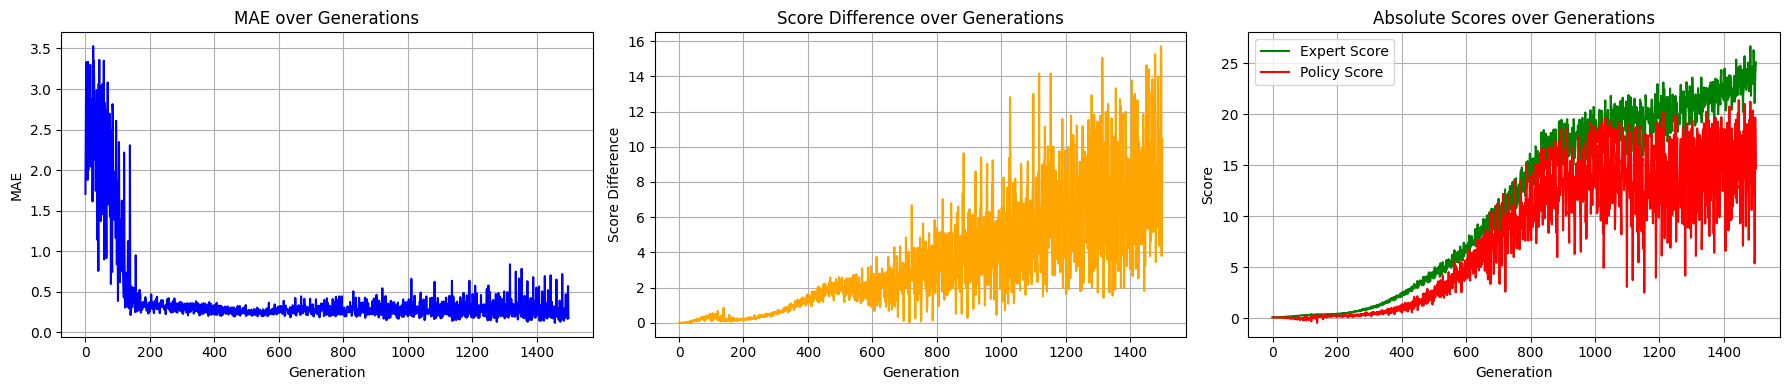

In [ ]:
%matplotlib inline
gens = np.arange(len(mmd_list))

disc_df = pd.DataFrame(disc_metrics_list)
disc_df["gen"] = (disc_df.index // dis_balance_factor) + 1
disc_mean = disc_df.groupby("gen").mean(numeric_only=True).sort_index()

score_diffs = (disc_mean["expert_score_mean"] - disc_mean["policy_score_mean"]).abs().to_numpy()
abs_scores = disc_mean[["expert_score_mean", "policy_score_mean"]].to_numpy()

fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharex=True)

axes[0].plot(gens, mmd_list, color="blue")
axes[0].set_xlabel("Generation")
axes[0].set_ylabel("MMD")
axes[0].set_title("MMD over Generations")
axes[0].grid(True)

axes[1].plot(gens, score_diffs, color="orange")
axes[1].set_xlabel("Generation")
axes[1].set_ylabel("Score Difference")
axes[1].set_title("Score Difference over Generations")
axes[1].grid(True)

axes[2].plot(gens, abs_scores[:, 0], label="Expert Score")
axes[2].plot(gens, abs_scores[:, 1], label="Policy Score")
axes[2].set_xlabel("Generation")
axes[2].set_ylabel("Score")
axes[2].set_title("Absolute Scores over Generations")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
pin_delta_norm = np.array([pm[0].get("delta_norm", np.nan) for pm in policy_metrics_list], dtype=float)
an_delta_norm  = np.array([pm[1].get("delta_norm", np.nan) for pm in policy_metrics_list], dtype=float)

pin_diff_std = np.array([pm[0].get("diff_std", np.nan) for pm in policy_metrics_list], dtype=float)
an_diff_std  = np.array([pm[1].get("diff_std", np.nan) for pm in policy_metrics_list], dtype=float)


fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

axes[0].plot(gens, pin_delta_norm, label="PIN delta_norm")
axes[0].plot(gens, an_delta_norm, label="AN delta_norm")
axes[0].set_xlabel("Generation")
axes[0].set_ylabel("delta_norm")
axes[0].set_title("ES step size per generation")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(gens, pin_diff_std, label="PIN diff_std")
axes[1].plot(gens, an_diff_std, label="AN diff_std")
axes[1].set_xlabel("Generation")
axes[1].set_ylabel("diff_std")
axes[1].set_title("Reward-diff std per generation")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
mpl.use('TkAgg')
_, gen_prey_tensor = run_env_simulation(visualization='on', prey_policy=prey_policy, pred_policy=pred_policy,
        n_prey=32, n_pred=0, max_steps=200,
        pred_speed=5, prey_speed=5,
        area_width=50, area_height=50, device=sim_device
    )

In [ ]:
#mpl.use('TkAgg')
_, exp_tensor, _ = run_couzin_simulation(visualization="on", max_steps=100, alpha=0.01, 
                                         constant_speed=5, shark_speed=5, 
                                         area_width=50, area_height=50,
                                         number_of_sharks=0, n=32)